## 1. RNN (Bidirectional LSTM)

This model architecture, featuring Bidirectional LSTM layers, GloVe embeddings, dense layers, and dropout regularization, is designed to efficiently capture the contextual dependencies in text data and perform accurate sentiment classification. By leveraging pre-trained embeddings and advanced RNN techniques, the model aims to achieve high accuracy while maintaining efficient training performance.

Imoprt libraries:

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/katarinalitricin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katarinalitricin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/katarinalitricin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Load and preprocess data

In [14]:
# Load the dataset
from datasets import load_dataset
dataset = load_dataset("sentiment140", split='train')
df = pd.DataFrame(dataset)

# Rename columns for convenience
df = df.rename(columns={"sentiment": "target", "text": "text"})

# Drop rows with NaN values
df.dropna(subset=['target', 'text'], inplace=True)

# Convert to binary classification (0: negative, 1: positive)
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text_cleaning_re = "@\\S+|https?:\\S+|http?:\\S|[^A-Za-z0-9]+"
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['text'] = df['text'].apply(preprocess_text)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)


/opt/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/datasets/load.py:1486: FutureWarning: The repository for sentiment140 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sentiment140
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Tokenize and Pad Sequences

In [15]:
# Tokenization and padding
max_length = 100
vocab_size = 20000
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)


Load GloVe Embeddings

In [16]:
# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


Build the RNN model:

In [17]:
# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_length,
                    trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          84480     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

### Architecture:

The RNN model was designed to achieve high accuracy while being efficient in training. Here's a detailed explanation of the architecture and the rationale behind each component:

- Embedding Layer

The embedding layer transforms input words into dense vector representations using pre-trained GloVe embeddings. GloVe (Global Vectors for Word Representation) embeddings are pre-trained on large corpora and capture semantic relationships between words. Using these embeddings helps our model leverage this rich, pre-existing knowledge, improving its performance even with limited training data. The layer takes sequences of integers (each representing a word) as input and produces dense vector representations for each word in the sequence.

- Bidirectional LSTM Layers

The Bidirectional LSTM layers capture long-term dependencies and context in the text data. LSTMs (Long Short-Term Memory networks) are a type of RNN capable of learning long-term dependencies, which is crucial for understanding context in text sequences. A Bidirectional LSTM processes the input sequence in both forward and backward directions, allowing the model to have access to past and future context, improving its ability to understand the sentiment of a text. The first Bidirectional LSTM outputs sequences to capture intermediate patterns, while the second Bidirectional LSTM further processes these sequences to capture higher-level patterns.

- Dense Layer

The dense layer combines the features extracted by the LSTM layers and performs the final classification. Dense layers (fully connected layers) are used to combine the features learned by previous layers and make the final classification decision. We use a moderate number of units (64) to balance complexity and performance, and the ReLU (Rectified Linear Unit) activation function introduces non-linearity, enabling the model to learn more complex patterns.

- Dropout Layer

The dropout layer prevents overfitting by randomly setting a fraction of input units to 0 during training. Dropout is a regularization technique that helps prevent overfitting by ensuring the model does not rely too heavily on any single feature. A dropout rate of 0.5 is a common choice that balances regularization and performance.

- Output Layer

The output layer produces the final classification output. 

Train the model:

In [21]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/10
16000/16000 [==============================] - 2728s 171ms/step - loss: 0.4933 - accuracy: 0.7607 - val_loss: 0.4669 - val_accuracy: 0.7759 - lr: 0.0010
Epoch 2/10
16000/16000 [==============================] - 2721s 170ms/step - loss: 0.4617 - accuracy: 0.7817 - val_loss: 0.4600 - val_accuracy: 0.7795 - lr: 0.0010
Epoch 3/10
16000/16000 [==============================] - 2759s 172ms/step - loss: 0.4487 - accuracy: 0.7892 - val_loss: 0.4537 - val_accuracy: 0.7839 - lr: 0.0010
Epoch 4/10
16000/16000 [==============================] - 2899s 181ms/step - loss: 0.4386 - accuracy: 0.7949 - val_loss: 0.4553 - val_accuracy: 0.7862 - lr: 0.0010
Epoch 5/10
16000/16000 [==============================] - 3374s 211ms/step - loss: 0.4298 - accuracy: 0.8002 - val_loss: 0.4534 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 6/10
16000/16000 [==============================] - 3211s 201ms/step - loss: 0.4219 - accuracy: 0.8047 - val_loss: 0.4563 - val_accuracy: 0.7849 - lr: 0.0010
Epoch 7/10
16000

### Training Process

To train the model efficiently and achieve high accuracy, we use the Adam optimizer, binary cross-entropy loss function, and two callbacks: Early Stopping and ReduceLROnPlateau.

The Adam optimizer is chosen for its adaptive learning rate and efficient handling of sparse gradients, making it well-suited for text data. The binary cross-entropy loss function measures the error between predicted probabilities and the actual binary labels, which is appropriate for our binary classification task.

Early Stopping stops training when the validation loss stops improving, preventing overfitting and saving computational resources. ReduceLROnPlateau reduces the learning rate when the validation loss plateaus, helping the model converge more effectively.

### Plot Training and Validation Accuracy: 

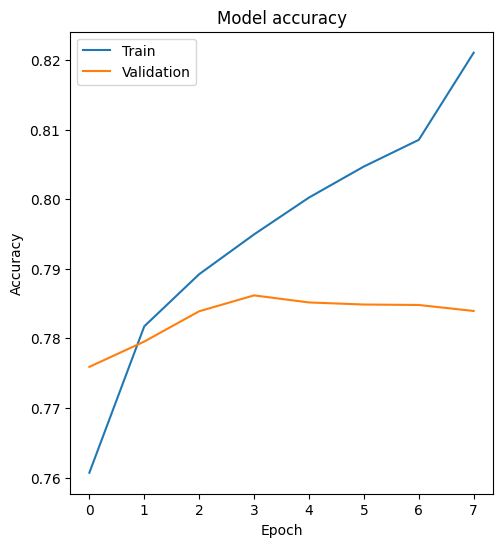

In [23]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


As we can see from the plot, the early stopping mechanism successfully prevents further overfitting by halting training when validation accuracy stops improving. Training accuracy continues to increase beyond epoch 4, while validation accuracy starts to decline slightly, indicating potential overfitting.

Moreover, both training and validation accuracy improve significantly in the first few epochs, indicating that the model is learning effectively. Validation accuracy plateaus around epoch 3, suggesting that the model's generalization performance stabilizes early.

### Plot Training and Validation Loss:

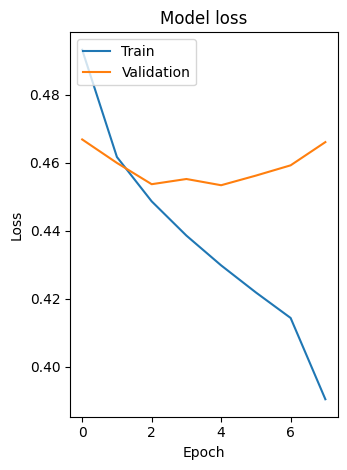

In [24]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


- Both training and validation loss decrease significantly in the early epochs, indicating effective learning. 
- Validation loss plateaus around epoch 3, suggesting stabilization in generalization performance. 
- Training loss continues to decrease while validation loss increases after epoch 4, indicating potential overfitting.
- Training halted at epoch 8 due to early stopping, preventing further overfitting.